指标和结果的统计
数据统计

一、提取历史所有交易日的股票数据，并去掉停牌日的信息；
二、记录每一天的指标和输赢结果。对于每一个不停牌的交易日T，做：
 a. 计算当日的指标Ind(T)，方便统计需要，四舍五入到合适的小数点位；
 b. 计算从T日起观测的输赢结果；
 c. 记录事件组(Ind(T),赢或平或输)。
三、统计指标的某个值出现后赢和平和输分别发生过多少次。

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

prices = get_price("000300.XSHG",start_date='2006-01-01',end_date='2017-01-01',fields = 'ClosingPx')

In [32]:
def get_stats(prices):
    # 设置一个计数器
    i = 5
    # 设置一个空list
    data = []
    # 从第一个到倒数第二个价格
    while i < len(prices)-4:
        # 计算五日收益率，留小数点后2位
        ratio = 0.01 * ((prices[i]/prices[i-5]) //0.01)
        # 如果第五天收盘价更高
        if prices[i+4] > prices[i]:
            # 那结果记赢
            result = 'win'
        # 如果第五天收盘价更低
        if prices[i+4] < prices[i]:
            # 结果记输
            result = 'lose'
        # 收盘价不变的话
        if prices[i] == prices[i+4]:
            # 记平
            result = 'even'
        # 看看该比例有无记载过
        ratio_recorded = False
        # 翻看data
        for data_dict in data:
            # 如果比例被记载过
            if data_dict['value'] == ratio:
                # 那就好，更新输赢
                data_dict[result] += 1
                # 记载过为是
                ratio_recorded = True
        # 如果翻完了发现没记载过，
        if ratio_recorded == False:
            # 那么就记载下来
            data_dict = {'value':ratio, 'win':0, 'lose':0, 'even':0}
            data_dict[result] += 1
            data.append(data_dict)
        # 别忘更新i
        i += 1
    # 转换成DataFrame
    df = pd.DataFrame(data,  columns=['value', 'win','even', 'lose'])
    # 按照value列从小到大排序
    df = df.sort(['value'], ascending = True)
    return(df)

In [33]:
stats = get_stats(prices)
stats.head(10)

/srv/env/bin/rq-research-kernel:43: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,value,win,even,lose
36,0.77,1,0,0
35,0.79,1,0,0
34,0.80,1,0,0
28,0.83,0,0,1
29,0.84,1,0,3
37,0.85,1,0,0
23,0.86,3,0,3
24,0.87,4,0,4
21,0.88,5,0,4
27,0.89,12,0,5


In [19]:
def DrawBarPic(stats):
    # 设置图的大小
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 15
    fig_size[1] = 10

    # 把统计的DataFrame中竖列抽出来
    values = stats['value']
    wins = stats['win']
    evens = stats['even']
    loses = stats['lose']

    # 画输的数目，颜色为红
    p1 = plt.bar(values, loses, width = 0.008, color='r')
    # 画平的数目，颜色为黄，底部在输之上
    p2 = plt.bar(values, evens, width= 0.008,  bottom = loses, color='y')
    # 画赢的数目，颜色为绿，底部在输+平之上
    p3 = plt.bar(values, wins, width=0.008, bottom = evens+loses, color='g')

    # 标注坐标轴和注释
    plt.ylabel('输赢结果',size = 15)
    plt.xlabel('收益率',size = 15)
    plt.legend((p1[0], p2[0],p3[0]), ('输', '平','赢'))

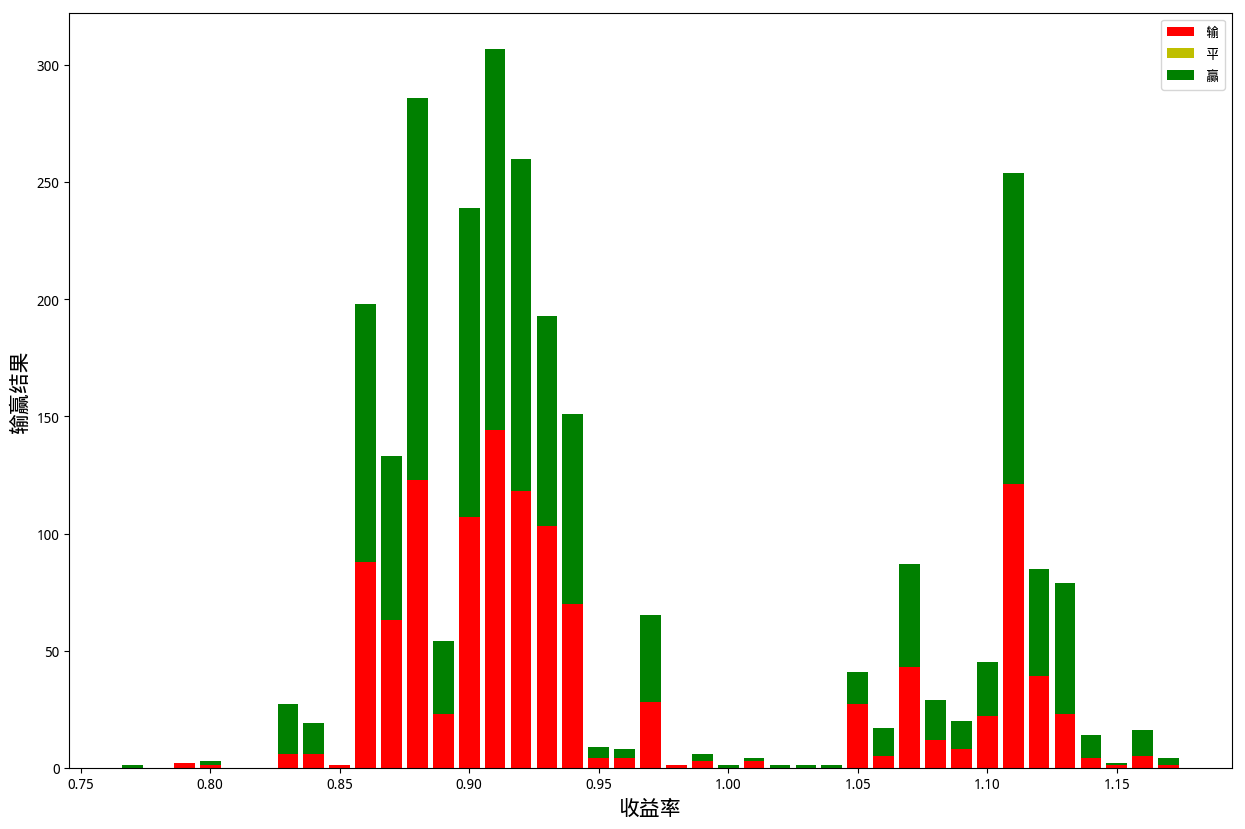

In [34]:
DrawBarPic(stats)

In [35]:
def DrawDValuePic(stats):
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 15
    fig_size[1] = 10

    # 把统计的DataFrame中竖列抽出来
    values = stats['value']
    wins = stats['win']
    evens = stats['even']
    loses = stats['lose']
    
    # 画赢数减去输数
    pdifference = plt.bar(values, wins - loses, width = 0.008, color='b')

    # 标注坐标轴和注释
    plt.ylabel('赢减去输',size = 15)
    plt.xlabel('5日收益率',size = 15)

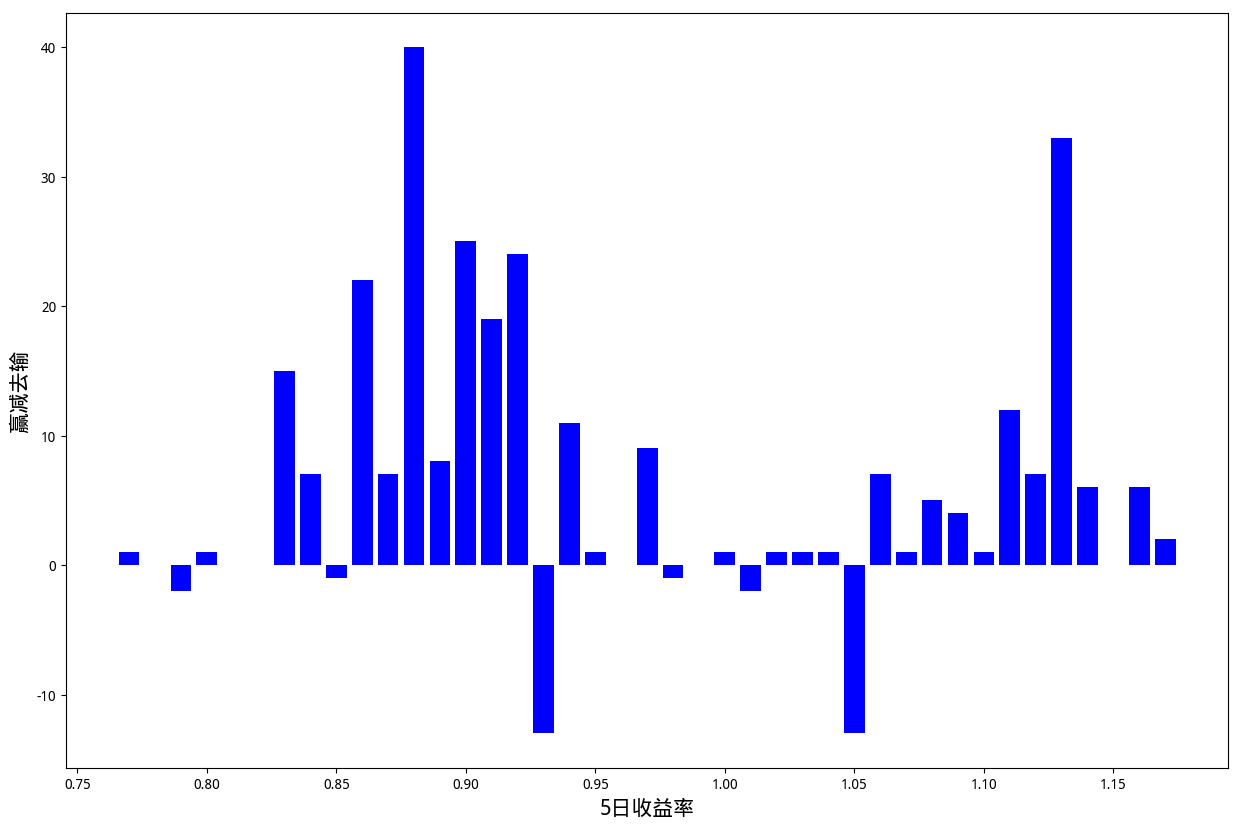

In [36]:
DrawDValuePic(stats)

In [37]:
# 下面函数的4个输入分别为：
# statistics – 之前算出的DataFrame统计数据
# tick_width – 指标值的最小间隔（跳动值，比如上面的示例里就是0.01）
# least_percentage – 要求区间数据量至少有总数据量的多少
# band_width – 区间的宽度，整数，可理解为进行多少次tick_width的跳动。

# 返回一Series，内容 low=区间低点，high=区间高点，ratio=区间赢输比
def find_best_region(statistics, tick_width, least_percentage, band_width):
    # 取出统计df的列
    values = statistics['value']
    loses = statistics['lose']
    wins = statistics['win']
    evens = statistics['even']
    # 算总数据量
    num_data = sum(wins) + sum(loses) + sum(evens)
    # 起始一list
    mydata = []
    # 计算指标统计出的最低值除以间距，取整数，方便后面移动计算。
    low_bound = int(statistics['value'].iloc[0]/tick_width)
    # 计算指标统计出的最高值除以间距，减去区间宽度
    high_bound = int(statistics['value'].iloc[-1]/tick_width - band_width + 1)
    # 对于上限和下限之间的所有整数
    for n in range(low_bound, high_bound ):
        # 选取统计中所对应的区间
        statistics1 = statistics[values >= float(n)*tick_width]
        stat_in_range  = statistics1[values <= float(n + band_width - 1) * tick_width]
        # 计算区间中的赢输比。输数加一，避免除以零。
        ratio = float(sum(stat_in_range['win'])) / float(sum(stat_in_range['lose'])+1)
        # 计算区间中数据量
        range_data = float(sum(stat_in_range['win']) + sum(stat_in_range['lose']) + sum(stat_in_range['even']))
        # 如果区间数据量除以总数据量大于最低数据比
        if range_data / num_data >= least_percentage:
            # 记录区间的最低值，最高值，和区间内的赢输比
            mydata.append({'low': float(n) * tick_width, 'high': float(n+band_width) * tick_width, 'ratio': ratio})
    # 制作DataFrame
    data_table = pd.DataFrame(mydata)
    # 按照赢输比排序
    sorted_table = data_table.sort('ratio', ascending = False)
    # 返回第一行
    return(sorted_table.iloc[0])

In [38]:
find_best_region(stats,0.01, 0.03, 4)

/srv/env/bin/rq-research-kernel:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/srv/env/bin/rq-research-kernel:38: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


high     1.100000
low      1.060000
ratio    2.050847
Name: 17, dtype: float64

In [39]:
# statistics – 之前算出的DataFrame统计数据
# tick_width – 指标值的最小间隔（跳动值，比如上面的示例里就是0.01）
# least_percentage – 要求区间数据量至少有总数据量的多少
# least_width – 最短的区间宽度
# most_width – 最大的区间宽度

# 返回一Series，内容 low=区间低点，high=区间高点，ratio=区间赢输比
def find_absolute_best_region(statistics, tick_width, least_percentage, least_width, most_width):
    # 创建标注列的空DF
    columns = ['low', 'high', 'ratio']
    df = pd.DataFrame(columns = columns)
    # 对于所有在最短和最长标准之间的宽度
    for band_width in range(least_width, most_width + 1):
        # 运行上面函数，得到该宽度的最佳区间
        best_width_region = find_best_region(statistics, tick_width, least_percentage, band_width)
        # 将结果加入DF
        df = df.append(best_width_region, ignore_index = True)
    # 将赢输比从大到小排列
    sorted_table = df.sort('ratio', ascending = False)
    # 返回第一行
    return(sorted_table.iloc[0])

In [40]:
find_absolute_best_region(stats, 0.01, 0.05, 2, 30)

/srv/env/bin/rq-research-kernel:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/srv/env/bin/rq-research-kernel:38: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/srv/env/bin/rq-research-kernel:19: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


low      1.060000
high     1.130000
ratio    2.101449
Name: 5, dtype: float64